In [1]:
# Uncomment to use autoreload
%load_ext autoreload
%autoreload 2

import os
import os.path as osp
import sys
import torch
import numpy as np
from time import time
from omegaconf import OmegaConf
start = time()
import warnings
warnings.filterwarnings('ignore')

# torch.cuda.set_device(I_GPU)
DIR = os.path.dirname(os.getcwd())
ROOT = os.path.join(DIR, "..")
sys.path.insert(0, ROOT)
sys.path.insert(0, DIR)

from torch_points3d.utils.config import hydra_read
from torch_geometric.data import Data
from torch_points3d.core.multimodal.data import MMData, MMBatch
from torch_points3d.visualization.multimodal_data import visualize_mm_data
from torch_points3d.core.multimodal.image import SameSettingImageData, ImageData
from torch_points3d.datasets.segmentation.multimodal.scannet import ScannetDatasetMM
from torch_points3d.datasets.segmentation.scannet import CLASS_COLORS, CLASS_NAMES, CLASS_LABELS
from torch_points3d.metrics.segmentation_tracker import SegmentationTracker
from torch_points3d.datasets.segmentation import IGNORE_LABEL
from torch_points3d.metrics.scannet_segmentation_tracker import ScannetSegmentationTracker
from torch_points3d.metrics.colored_tqdm import Coloredtqdm as Ctq


CLASS_COLORS[0] = (174.0, 199.0, 232.0)
CLASS_COLORS[-1] = (0, 0, 0)
import plotly.io as pio
import seaborn as sns

#pio.renderers.default = 'jupyterlab'        # for local notebook
pio.renderers.default = 'iframe_connected'  # for remote notebook. Other working (but seemingly slower) options are: 'sphinx_gallery' and 'iframe'

import matplotlib.pyplot as plt 
%matplotlib inline

MMData debug() function changed, please uncomment the 3rd assert line when doing inference without M2F features!


In [2]:
def get_seen_points(mm_data):
    ### Select seen points
    csr_idx = mm_data.modalities['image'][0].view_csr_indexing
    dense_idx_list = torch.arange(mm_data.modalities['image'][0].num_points).repeat_interleave(csr_idx[1:] - csr_idx[:-1])
    # take subset of only seen points without re-indexing the same point
    mm_data = mm_data[dense_idx_list.unique()]
    return mm_data

def get_mode_pred(data):
    pixel_validity = data.data.mvfusion_input[:, :, 0].bool()
    mv_preds = data.data.mvfusion_input[:, :, -1].long()
            
    valid_m2f_feats = []
    for i in range(len(mv_preds)):
        valid_m2f_feats.append(mv_preds[i][pixel_validity[i]])

    mode_preds = []
    for m2feats_of_seen_point in valid_m2f_feats:
        mode_preds.append(torch.mode(m2feats_of_seen_point.squeeze(), dim=0)[0])
    mode_preds = torch.stack(mode_preds, dim=0)
        
    return mode_preds

def get_random_view_pred(data):
    pixel_validity = data.data.mvfusion_input[:, :, 0].bool()
    mv_preds = data.data.mvfusion_input[:, :, -1].long()
            
    valid_m2f_feats = []
    for i in range(len(mv_preds)):
        valid_m2f_feats.append(mv_preds[i][pixel_validity[i]])

    selected_view_preds = []
    for m2feats_of_seen_point in valid_m2f_feats:
        selected_idx = torch.randint(low=0, high=m2feats_of_seen_point.shape[0], size=(1,))
        selected_pred = m2feats_of_seen_point[selected_idx].squeeze(0)
        selected_view_preds.append(selected_pred)
    selected_view_preds = torch.stack(selected_view_preds, dim=0)
        
    return selected_view_preds


In [3]:
# Set your dataset root directory, where the data was/will be downloaded
DATA_ROOT = '/scratch-shared/fsun/dvata'

dataset_config = 'segmentation/multimodal/Feng/scannet-neucon-smallres-m2f-allviews'   


print("Load MVFusion_3D")
models_config = 'segmentation/multimodal/Feng/mvfusion'    # model family
model_name = 'MVFusion_3D_small'                       # specific model


# print("Load MVFusion")
# dataset_config = 'segmentation/multimodal/Feng/scannet-neucon-smallres-m2f-no-transforms'   
# models_config = 'segmentation/multimodal/Feng/mvfusion_orig'    # model family
# model_name = 'MVFusion_orig'

overrides = [
    'task=segmentation',
    f'data={dataset_config}',
    f'models={models_config}',
    f'model_name={model_name}',
    f'data.dataroot={DATA_ROOT}',
]

cfg = hydra_read(overrides)
OmegaConf.set_struct(cfg, False)  # This allows getattr and hasattr methods to function correctly
cfg.data.load_m2f_masks = True   # load Mask2Former predicted masks
cfg.data.m2f_preds_dirname = 'm2f_masks'
cfg.data.n_views = cfg.models[model_name].backbone.transformer.n_views
print(cfg.data.n_views)

# Dataset instantiation
start = time()
dataset = ScannetDatasetMM(cfg.data)
# print(dataset)|
print(f"Time = {time() - start:0.1f} sec.")

Load MVFusion_3D
9
Load predicted 2D semantic segmentation labels from directory  m2f_masks
initialize train dataset
initialize val dataset
Time = 7.8 sec.


In [6]:
from torch_points3d.models.model_factory import instantiate_model

# ViT_masks 3rd run
# checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/ViT_masks_3rd_run' # 3rd run

# ViT_masks 9 views, MVFusion_3D_small
checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/2023-01-25/16-02-53'


# # MVFusion_orig
# checkpoint_dir = '/home/fsun/DeepViewAgg/outputs/MVFusion_orig'



# Create the model
print(f"Creating model: {cfg.model_name}")
model = instantiate_model(cfg, dataset)
# print(model)

# Load the checkpoint and recover the 'best_miou' model weights
checkpoint = torch.load(f'{checkpoint_dir}/{model_name}.pt', map_location='cpu')
model.load_state_dict_with_same_shape(checkpoint['models']['best_miou'], strict=False)

# Prepare the model for training
model = model.cuda()
print('Model loaded')

Creating model: MVFusion_3D_small
task:  segmentation.multimodal
tested_model_name:  MVFusion_3D_small
class_name:  MVFusionAPIModel
model_module:  torch_points3d.models.segmentation.multimodal.Feng.mvfusion_3d
name, cls of chosen model_cls:  MVFusionAPIModel <class 'torch_points3d.models.segmentation.multimodal.Feng.mvfusion_3d.MVFusionAPIModel'>
x feature dim:  {'FEAT': 3}
nc_in:  67
nc_in:  64
nc_in:  32
nc_in:  64
nc_in:  128
Return attention maps!
nc_in:  256
nc_in:  128
nc_in:  128
nc_in:  96
nc_in:  96
Model loaded


In [7]:
import pandas as pd
pd.set_option('display.max_rows', 100)



# Quick data analysis 
 - confusion count of all 2D input masks, then visualize most confusing classes
 Goal is to visualize the class ambiguous errors made by the 2D network, and visualize the level of recovery by the refinement network.

In [91]:
# Load refined masks
# dataset.val_dataset.m2f_preds_dirname = 'm2f_masks_refined/Deepset_3D'
# dataset.val_dataset.gt_dir_name = 'm2f_masks_refined/Deepset_3D'
print(dataset.val_dataset.m2f_preds_dirname)
print(dataset.val_dataset.gt_dir_name)

# Create validation loader
dataset.create_dataloaders(
    model,
    1,
    False,
    17,
    False,
    train_only=False,
    val_only=True,
    test_batch_size=1
)

# Create segmentation tracker
tracker_input = ScannetSegmentationTracker(dataset=dataset, stage='val', wandb_log=False, use_tensorboard=False, ignore_label=IGNORE_LABEL)
tracker_refined = ScannetSegmentationTracker(dataset=dataset, stage='val', wandb_log=False, use_tensorboard=False, ignore_label=IGNORE_LABEL)


with Ctq(dataset.val_dataloader) as loader:
    for batch in loader:
        # Input and refined masks, labels sampled based on the 2D-3D mapping
        input_pred = batch.modalities['image'][0].get_mapped_m2f_features().flatten()
        refined_pred = batch.modalities['image'][0].get_mapped_gt_labels().flatten()# + 1   # label off-set 
        
        # Number of views for each point
        csr_idx = batch.modalities['image'][0].view_csr_indexing
        n_seen = csr_idx[1:] - csr_idx[:-1]
        
        gt = batch.y
        gt = torch.repeat_interleave(gt, n_seen)

        tracker_input.track(pred_labels=input_pred, gt_labels=gt, model=None)
        tracker_refined.track(pred_labels=refined_pred, gt_labels=gt, model=None)
        
print(tracker_input.get_metrics())
print(tracker_refined.get_metrics())



m2f_masks_refined/Deepset_3D


  0%|          | 0/312 [00:01<?, ?it/s]

{'val_acc': 88.22969695902036, 'val_macc': 80.20169583309666, 'val_miou': 69.20676894172828}
{'val_acc': 93.1142884372327, 'val_macc': 86.00916112202917, 'val_miou': 77.83391263623456}


In [14]:
def visualize_ambiguities(cm, cm_ref, K=15, plot=True):
    """
    Visualize precision of each actual-predicted class combination
    Returns the data of the top-K largest ambiguities (measured in precision)
    """

    sns.set(font_scale=5)
    # PRECISION
    cmn = cm.astype("float") / cm.sum(axis=-1)[:, np.newaxis]
    cmn[np.isnan(cmn) | np.isinf(cmn)] = 0
    
    if plot:
        fig, ax = plt.subplots(figsize=(40, 40))
        sns.heatmap(
            cmn, annot=True, fmt=".5f", xticklabels=CLASS_NAMES[:-1], yticklabels=CLASS_NAMES[:-1], annot_kws={"size": 20}
        )
        # g.set_xticklabels(g.get_xticklabels(), rotation = 35, fontsize = 20)
        plt.ylabel("Actual")
        plt.xlabel("Predicted")
        plt.tight_layout()
        plt.show()

    cmn_ref = cm_ref.astype("float") / cm_ref.sum(axis=-1)[:, np.newaxis]
    cmn_ref[np.isnan(cmn_ref) | np.isinf(cmn_ref)] = 0
    
    if plot:
        fig, ax = plt.subplots(figsize=(40, 40))
        sns.heatmap(
            cmn_ref, annot=True, fmt=".5f", xticklabels=CLASS_NAMES[:-1], yticklabels=CLASS_NAMES[:-1], annot_kws={"size": 20}
        )
        # g.set_xticklabels(g.get_xticklabels(), rotation = 35, fontsize = 20)
        plt.ylabel("Actual")
        plt.xlabel("Predicted")
        plt.tight_layout()
        plt.show()
    
    
    # Pick K largest ambiguities
    cmn[np.eye(cmn.shape[0]).astype(bool)] = 0

    ind = np.argpartition(cmn.flatten(), -K)[-K:]
    ind = ind[np.argsort(cmn.flatten()[ind])][::-1]

    row_idx = ind // 20
    col_idx = ind % 20

    data = {
        'actual': np.array(CLASS_NAMES)[row_idx],
        'predicted': np.array(CLASS_NAMES)[col_idx],
        'input': cmn[row_idx, col_idx],
        'refined': cmn_ref[row_idx, col_idx]     
    }
    
    return data
    

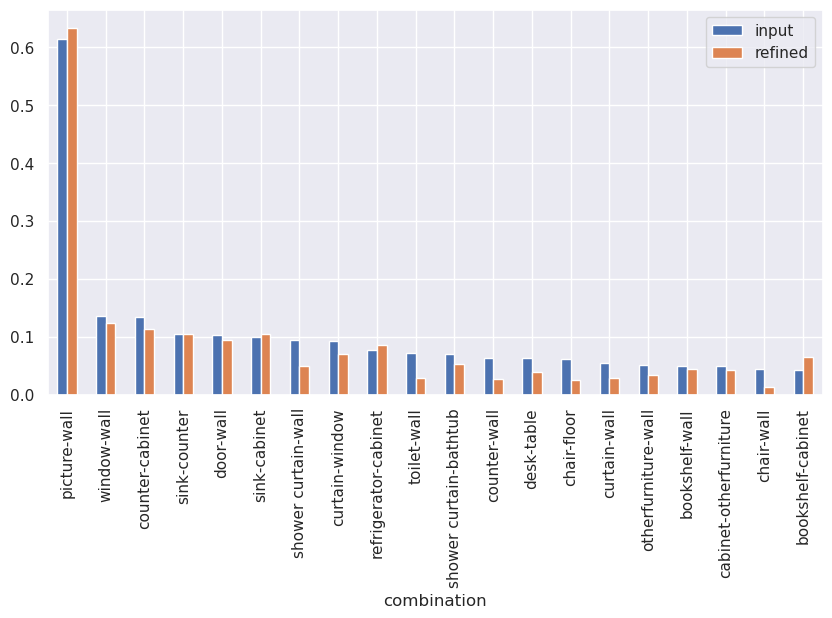

In [89]:
# 2D input/refined images, data sampled on 2D-3D mapping
# ViT_masks
data = visualize_ambiguities(tracker_input._confusion_matrix.get_confusion_matrix(), tracker_refined._confusion_matrix.get_confusion_matrix())

df = pd.DataFrame.from_dict(data)

df['combination'] = df['actual'] + '-' + df['predicted']
ax = df.plot(x="combination", y=["input", "refined"], kind="bar", rot=90, figsize=(10, 5))


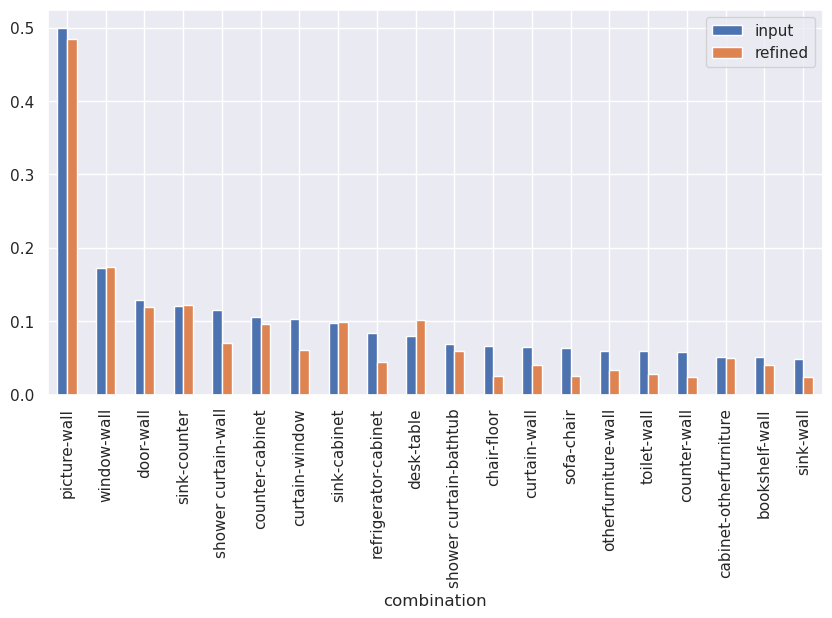

In [92]:
# 2D input/refined masks, sampled on 2D-3D mapping
# m2f_masks
data = visualize_ambiguities(tracker_input._confusion_matrix.get_confusion_matrix(), tracker_refined._confusion_matrix.get_confusion_matrix())

df = pd.DataFrame.from_dict(data)

df['combination'] = df['actual'] + '-' + df['predicted']
ax = df.plot(x="combination", y=["input", "refined"], kind="bar", rot=90, figsize=(10, 5))


In [9]:
# Load refined masks
dataset.val_dataset.m2f_preds_dirname = 'ViT_masks'
# dataset.val_dataset.m2f_preds_dirname = 'ViT_masks_refined/Deepset_3D'

dataset.val_dataset.gt_dir_name = 'label-filt-scannet20'
print(dataset.val_dataset.m2f_preds_dirname)
print(dataset.val_dataset.gt_dir_name)

# Create validation loader
dataset.create_dataloaders(
    model,
    1,
    False,
    17,
    False,
    train_only=False,
    val_only=True,
    test_batch_size=1
)

# Create segmentation tracker
tracker_input = ScannetSegmentationTracker(dataset=dataset, stage='val', wandb_log=False, use_tensorboard=False, ignore_label=IGNORE_LABEL)
# tracker_refined = ScannetSegmentationTracker(dataset=dataset, stage='val', wandb_log=False, use_tensorboard=False, ignore_label=IGNORE_LABEL)


with Ctq(dataset.val_dataloader) as loader:
    for batch in loader:
        # Input and refined masks
        input_pred = batch.modalities['image'][0].m2f_pred_mask.flatten()
#         refined_pred = batch.modalities['image'][0].m2f_pred_mask.flatten() + 1
                
        gt = batch.modalities['image'][0].gt_mask.flatten()

        tracker_input.track(pred_labels=input_pred, gt_labels=gt, model=None)
#         tracker_refined.track(pred_labels=refined_pred, gt_labels=gt, model=None)
        
print(tracker_input.get_metrics())
# print(tracker_refined.get_metrics())


""" 320 res.
ViT_masks 2D scores: 
{'val_acc': 89.31644714540938, 'val_macc': 83.28219859872569, 'val_miou': 73.08826563922885}

Deepset_3D 2D scores: 
{'val_acc': 92.66154205768436, 'val_macc': 86.49029384350854, 'val_miou': 78.65044825684092}
"""

ViT_masks
label-filt-scannet20


  0%|          | 0/312 [00:01<?, ?it/s]

{'val_acc': 89.31644714540938, 'val_macc': 83.28219859872569, 'val_miou': 73.08826563922885}


" 320 res.\nViT_masks 2D scores: \n{'val_acc': 89.31644714540938, 'val_macc': 83.28219859872569, 'val_miou': 73.08826563922885}\n\nDeepset_3D 2D scores: \n{'val_acc': 92.66154205768436, 'val_macc': 86.49029384350854, 'val_miou': 78.65044825684092}\n"

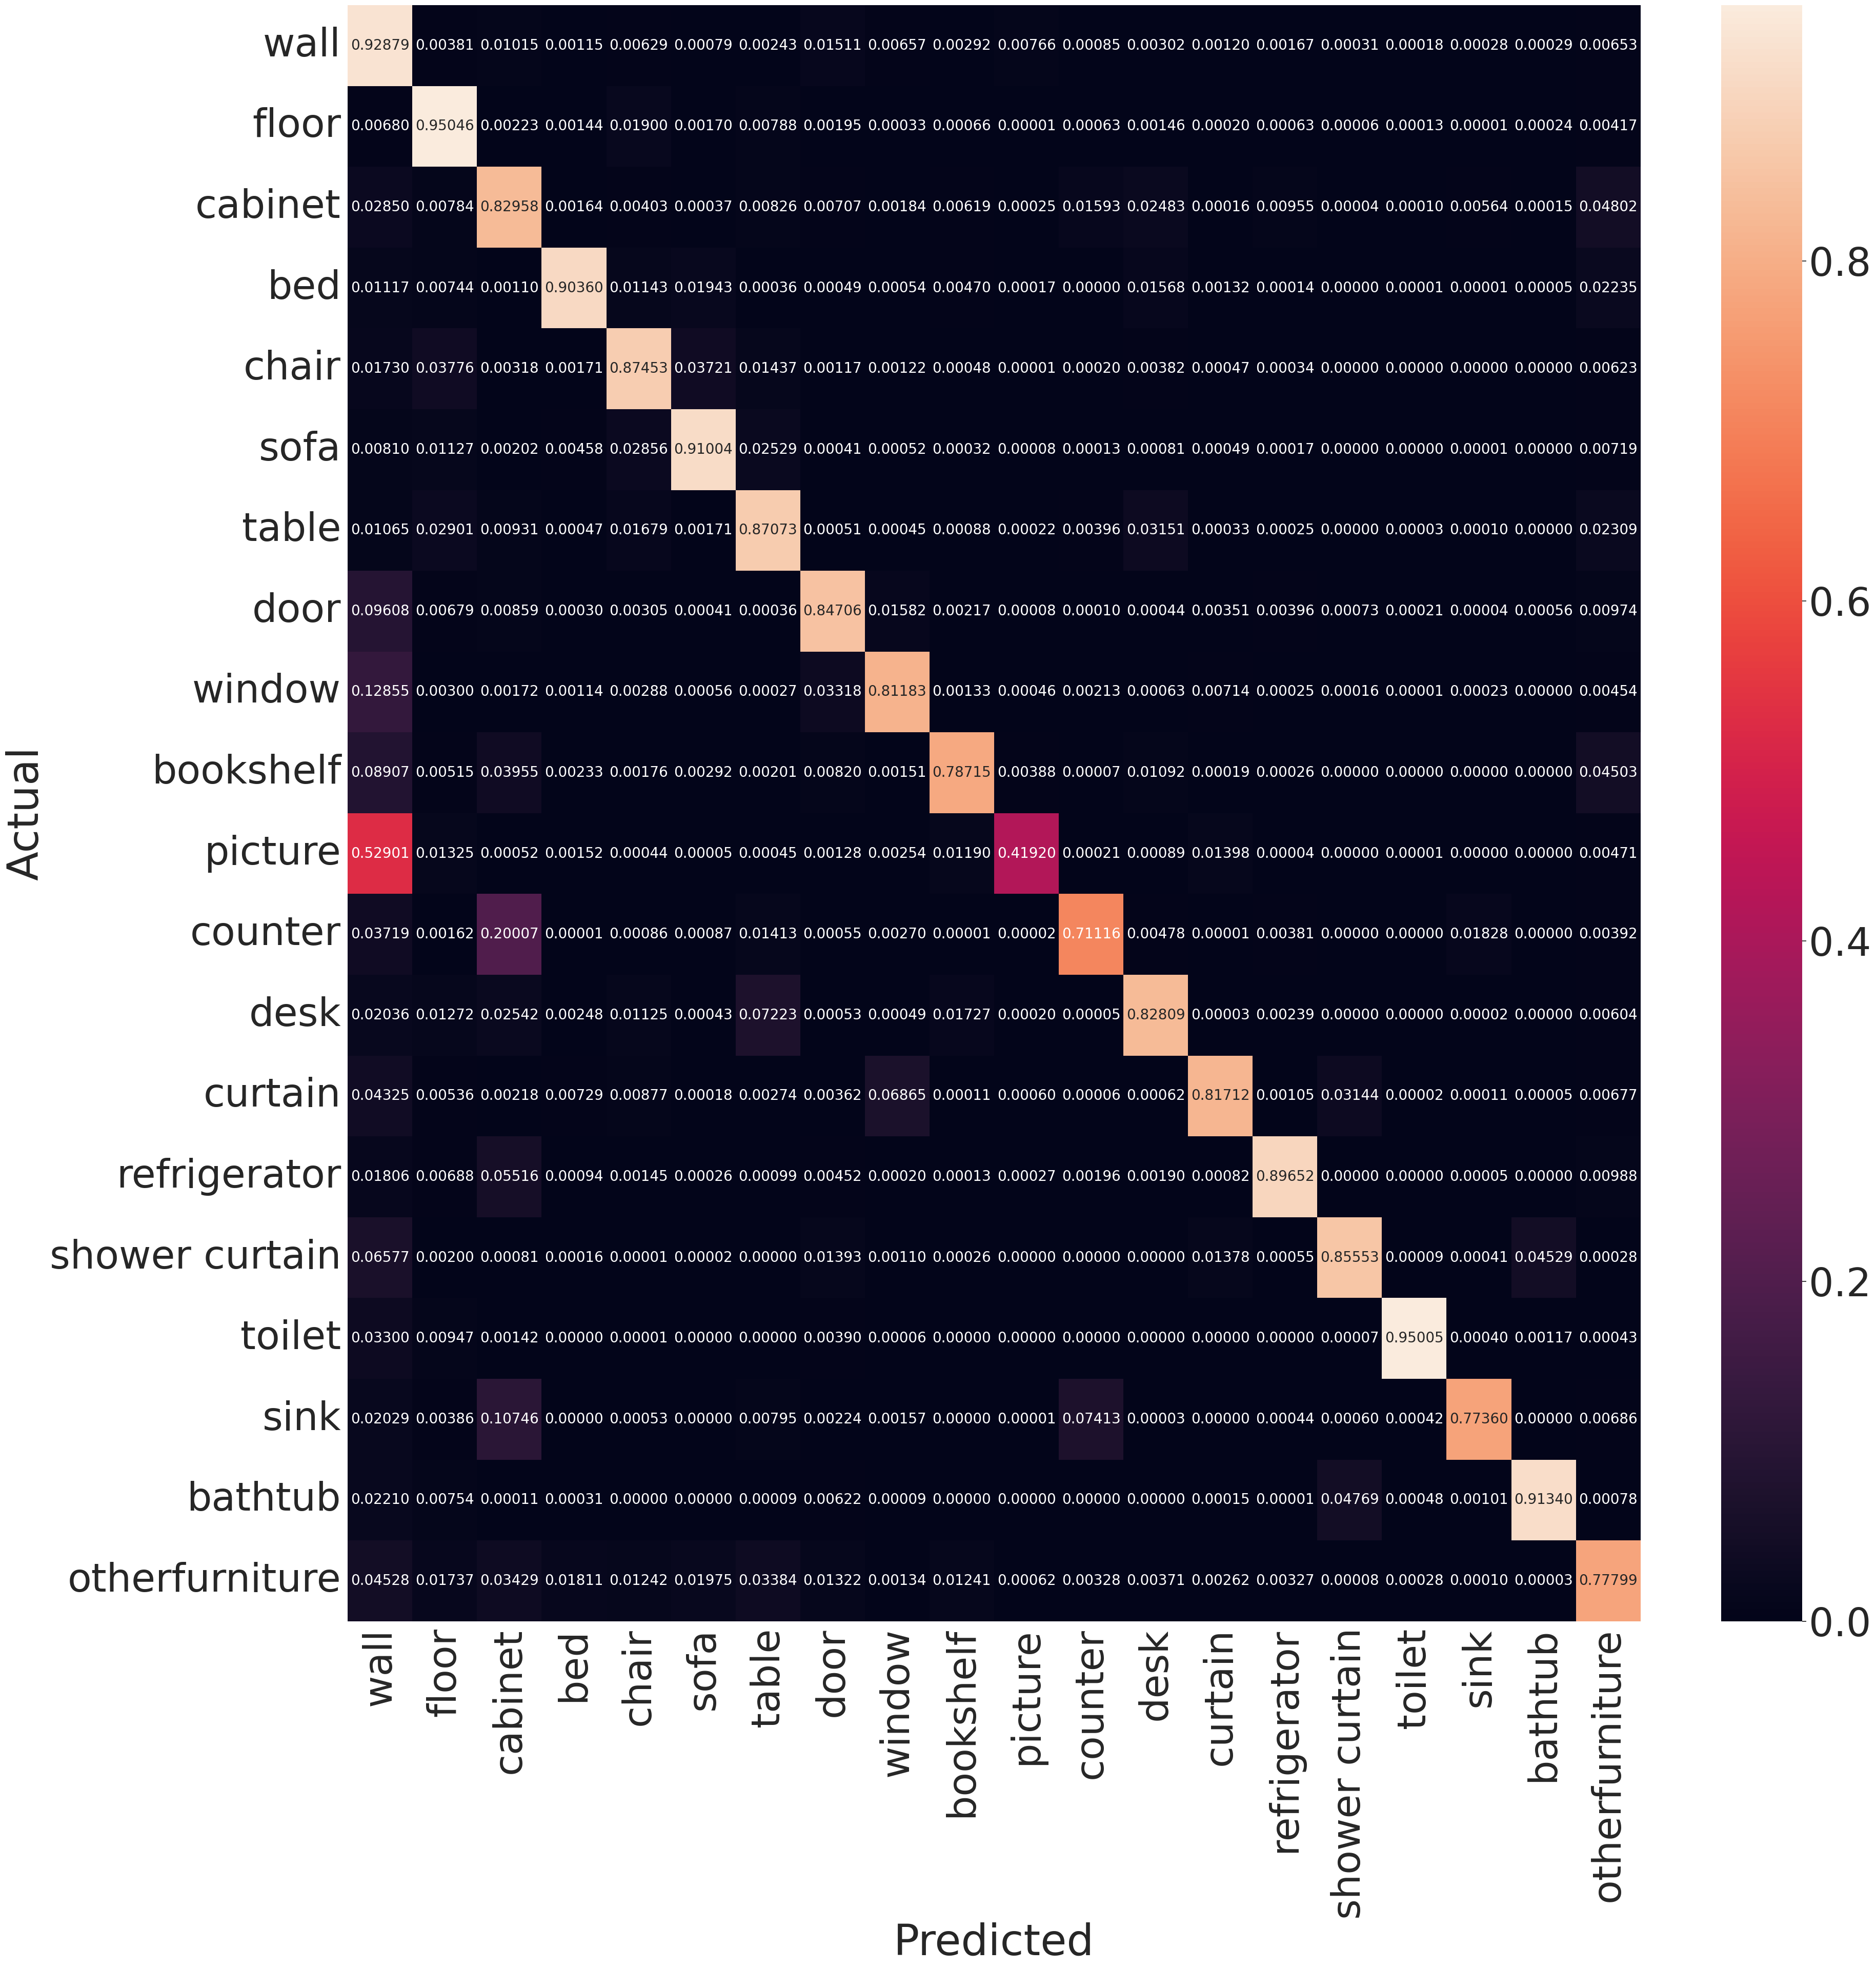

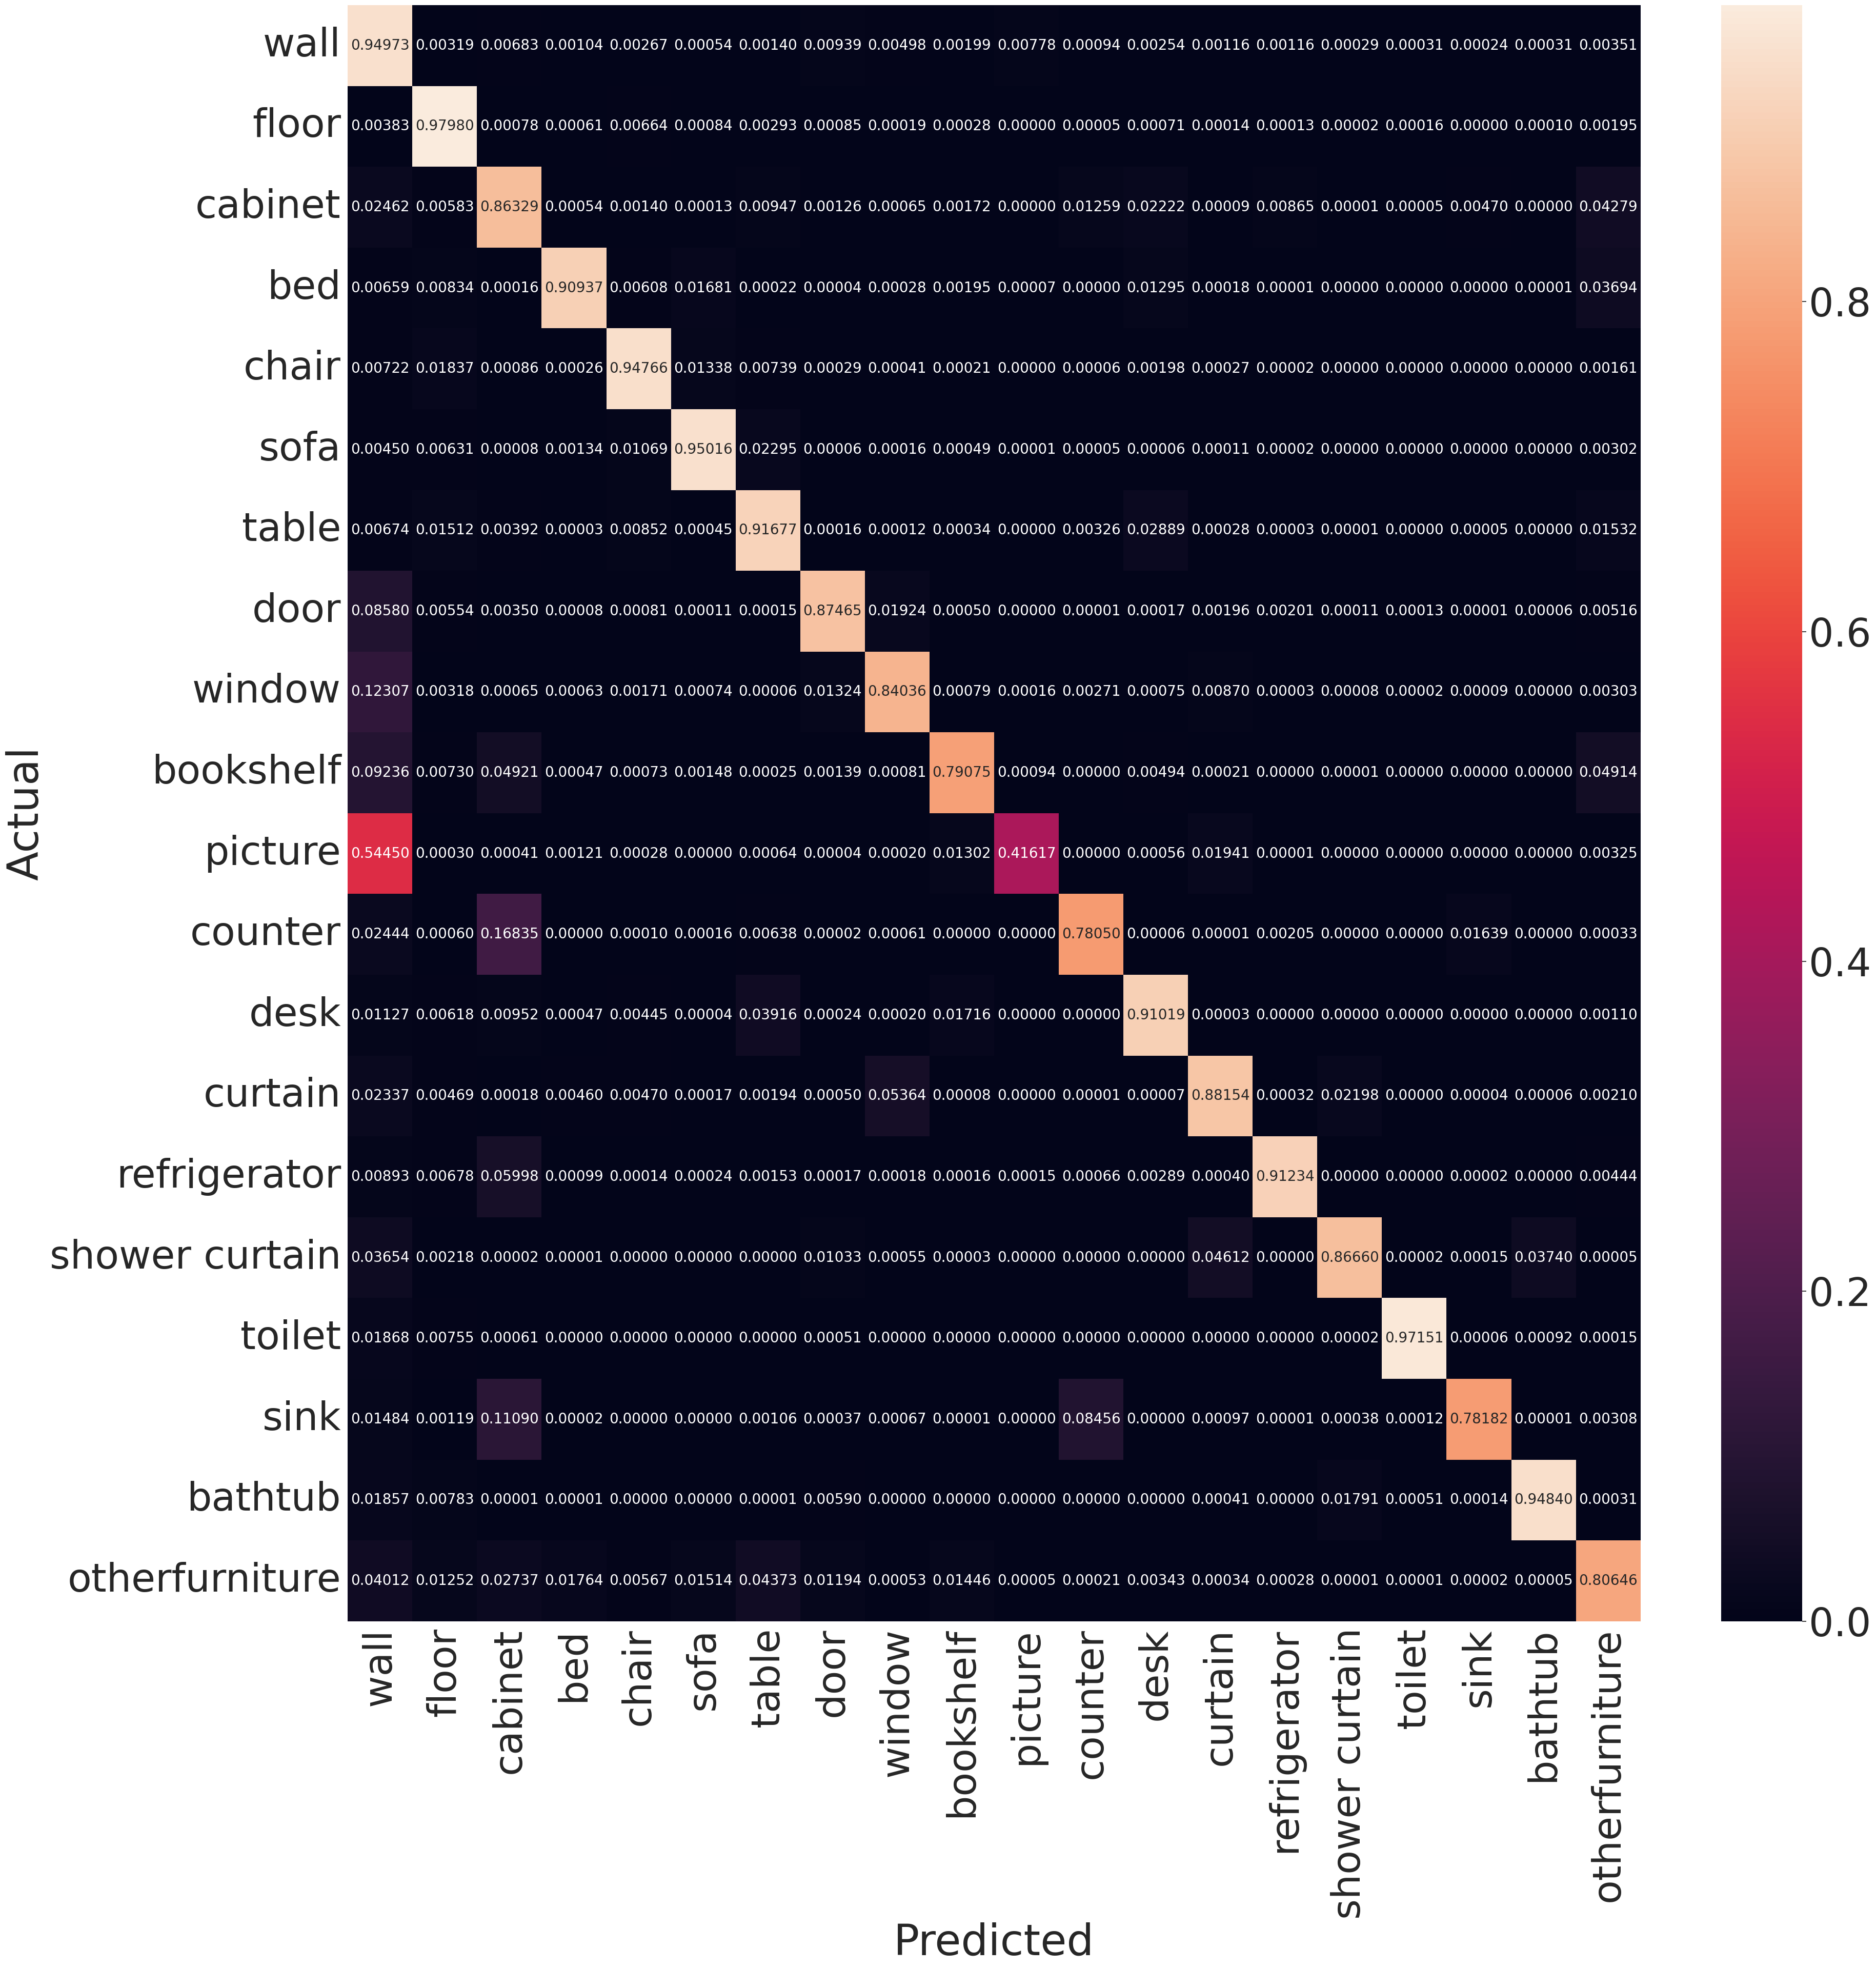

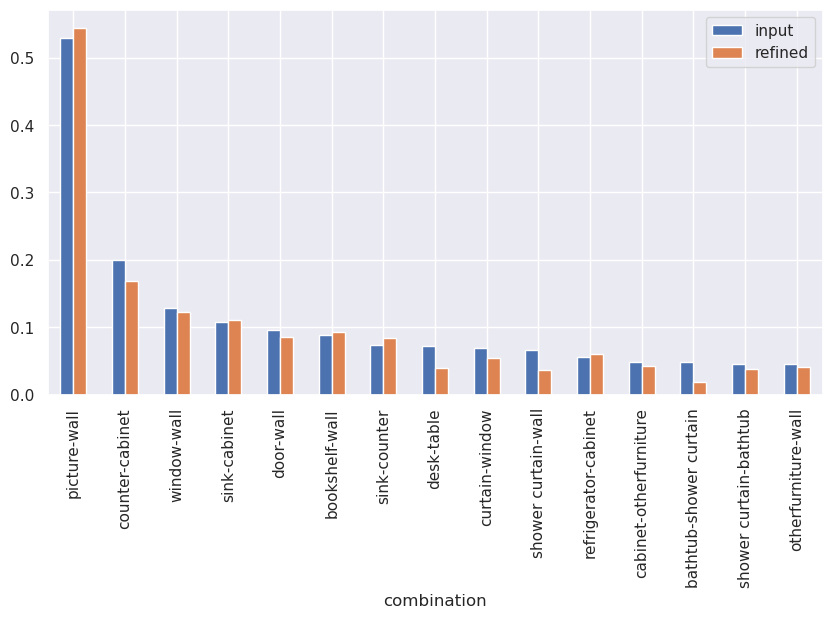

In [15]:
# 2D input/refined masks, sampled on 2D-3D mapping
# m2f_masks
data = visualize_ambiguities(tracker_input._confusion_matrix.get_confusion_matrix(), tracker_refined._confusion_matrix.get_confusion_matrix())

sns.set(font_scale=1)

df = pd.DataFrame.from_dict(data)

df['combination'] = df['actual'] + '-' + df['predicted']
ax = df.plot(x="combination", y=["input", "refined"], kind="bar", rot=90, figsize=(10, 5))


# Visualizations

In [46]:
import pandas as pd

def from_latex(l):
    l = l.replace("\textbf{", "").replace("}", "")
    l = l.split(" & ")
    l = [float(x) for x in l]
    return l
    



,class,CC,CC_ref,iou_3d,iou_3d_ref,iou_2d,iou_2d_ref,CC_rel,iou_3d_rel,iou_2d_rel
0,wall,82.47,87.13,85.5,89.7,86.9,89.8,5.65,4.91,3.34
1,floor,91.59,97.10,92.6,98.2,91.8,95.8,6.02,6.05,4.36
2,cabinet,74.71,84.83,68.4,75.5,68.2,75.1,13.55,10.38,10.12
3,bed,82.28,91.26,83.7,86.5,84.6,86.9,10.91,3.35,2.72
4,chair,63.15,91.20,75.8,93.7,80.0,90.9,44.42,23.61,13.63
5,sofa,77.88,91.73,77.8,85.7,76.2,85.5,17.78,10.15,12.20
6,table,64.93,87.30,71.6,82.1,79.8,85.9,34.45,14.66,7.64
7,door,67.67,77.87,73.2,78.0,73.9,80.4,15.07,6.56,8.80
8,window,65.26,69.07,70.6,74.5,69.6,73.9,5.84,5.52,6.18
9,bookshelf,80.45,91.13,76.6,81.7,74.2,77.4,13.28,6.66,4.31


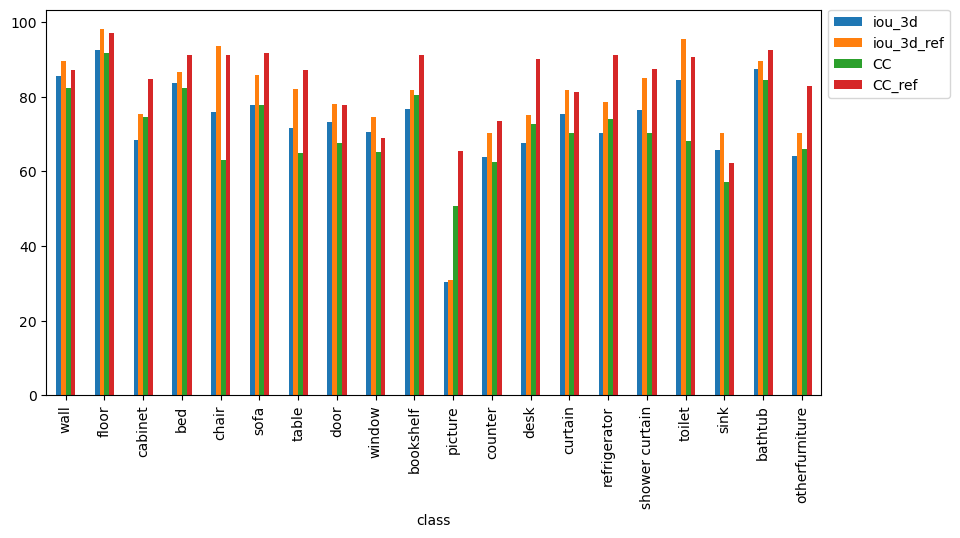

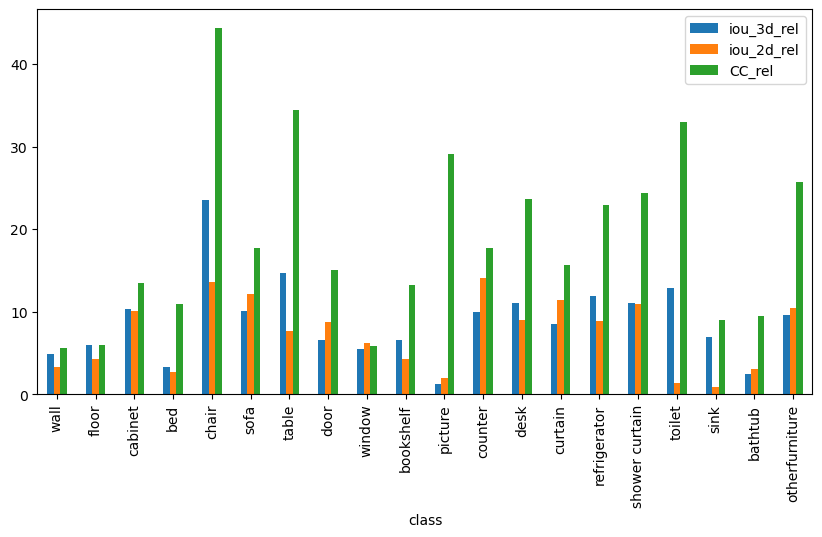

In [62]:
# ViT_masks - MVFusion_3D_small_6views

CC = "17.53 & 8.41 & 25.29 & 17.72 & 36.85 & 22.12 & 35.07 & 32.33 & 34.74 & 19.55 & 49.30 & 37.56 & 27.20 & 29.69 & 25.84 & 29.79 & 31.8 & 42.86 & 15.44 & 34.03"
CC_ref = "12.87 & 2.90 & 15.17 & 8.74 & 8.80 & 8.27 & 12.70 & 22.13 & 30.93 & 8.87 & 34.54 & 26.48 & 9.92 & 18.62 & 8.82 & 12.63 & 9.25 & 37.72 & 7.37 & 17.02"
iou_3d = "85.5 & 92.6 & 68.4 & 83.7 & 75.8 & 77.8 & 71.6 & 73.2 & 70.6 & 76.6 & 30.5 & 63.9 & 67.6 & 75.5 & 70.3 & 76.4 & 84.6 & 65.8 & 87.5 & 64.2"
iou_3d_ref = "\textbf{89.7} & \textbf{98.2} & \textbf{75.5} & \textbf{86.5} & \textbf{93.7} & \textbf{85.7} & 82.1 & \textbf{78.0} & \textbf{74.5} & \textbf{81.7} & 30.9 & \textbf{70.3} & \textbf{75.1} & \textbf{81.9} & \textbf{78.7} & \textbf{84.9} & \textbf{95.5} & 70.4 & \textbf{89.7} & \textbf{70.4}"
iou_2d = "86.9 & 91.8 & 68.2 & 84.6 & 80.0 & 76.2 & 79.8 & 73.9 & 69.6 & 74.2 & 36.1 & 58.3 & 68.4 & 73.5 & 78.4 & 76.4 & 93.5 & 73.3 & 85.4 & 60.0"
iou_2d_ref = "89.8 & 95.8 & 75.1 & 86.9 & 90.9 & 85.5 & 85.9 & 80.4 & 73.9 & 77.4 & 36.8 & 66.5 & 74.6 & 81.9 & 85.4 & 84.8 & 94.8 & 74.0 & 88.0 & 66.3"

data = {'class': CLASS_NAMES[:-1], 
        'CC': from_latex(CC), 
        'CC_ref': from_latex(CC_ref), 
        'iou_3d': from_latex(iou_3d), 
        'iou_3d_ref': from_latex(iou_3d_ref),
        'iou_2d': from_latex(iou_2d),
        'iou_2d_ref': from_latex(iou_2d_ref)}

df = pd.DataFrame.from_dict(data)

df['CC'] = 100 - df['CC']
df['CC_ref'] = 100 - df['CC_ref']

# Relative change in %
df['CC_rel'] = 100 * ( df['CC_ref'] - df['CC'] ) / df['CC']
df['iou_3d_rel'] = 100 * ( df['iou_3d_ref'] - df['iou_3d'] ) / df['iou_3d']
df['iou_2d_rel'] = 100 * ( df['iou_2d_ref'] - df['iou_2d'] ) / df['iou_2d']



ax = df.plot(x="class", y=["iou_3d", "iou_3d_ref", "CC", "CC_ref"], kind="bar", rot=90, figsize=(10, 5))
_ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')



ax = df.plot(x="class", y=["iou_3d_rel", "iou_2d_rel", "CC_rel"], kind="bar", rot=90, figsize=(10, 5))


df = df.round(2)
df

In [20]:
import matplotlib.pyplot as plt

import seaborn as sb

df = sb.load_dataset(' titanic')

df = df.groupby(['pclass', 'survived']).agg(mean=("age", 'mean'))

df = df.reset_index()

sb.barplot(x="pclass",

           y="mean",

           hue="survived",

           data=df)

plt.show()

ValueError: ' titanic' is not one of the example datasets.